In [1]:
# !pip uninstall virny -y

In [2]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from virny.datasets import CardiovascularDiseaseDataset
from virny.utils.model_tuning_utils import tune_ML_models
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart
from virny.utils.custom_initializers import create_models_config_from_tuned_params_df

from pprint import pprint
from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [6]:
DATASET_SPLIT_SEED = 100
MODELS_TUNING_SEED = 100
TEST_SET_FRACTION = 0.2
DATASET_NAME = 'Cardio'

sensitive_attributes_dct = {'gender': '1',  'age': [i for i in range(29, 46)], 'gender & age': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [7]:
data_loader = CardiovascularDiseaseDataset()
data_loader.full_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
data_loader.target

'cardio'

In [9]:
data_loader.full_df.shape

(70000, 12)

In [10]:
data_loader.full_df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [11]:
data_loader.full_df.nunique()

age             28
gender           2
height         109
weight         287
ap_hi          153
ap_lo          157
cholesterol      3
gluc             3
smoke            2
alco             2
active           2
cardio           2
dtype: int64

## Check proportions and base rates

In [12]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

### Data Profiling

In [13]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

gender: 2
cholesterol: 3
gluc: 3
smoke: 2
alco: 2
active: 2


In [14]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [15]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['gender_1',
 'gender_2',
 'cholesterol_1',
 'cholesterol_2',
 'cholesterol_3',
 'gluc_1',
 'gluc_2',
 'gluc_3',
 'smoke_0',
 'smoke_1',
 'alco_0',
 'alco_1',
 'active_0',
 'active_1',
 'age',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cardio']

### Correlation of sensitive attributes with the target

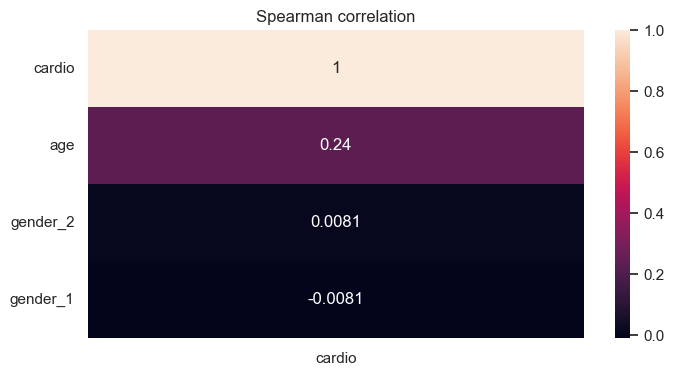

In [16]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(4, 8))

### Correlation of selected attributes with the target

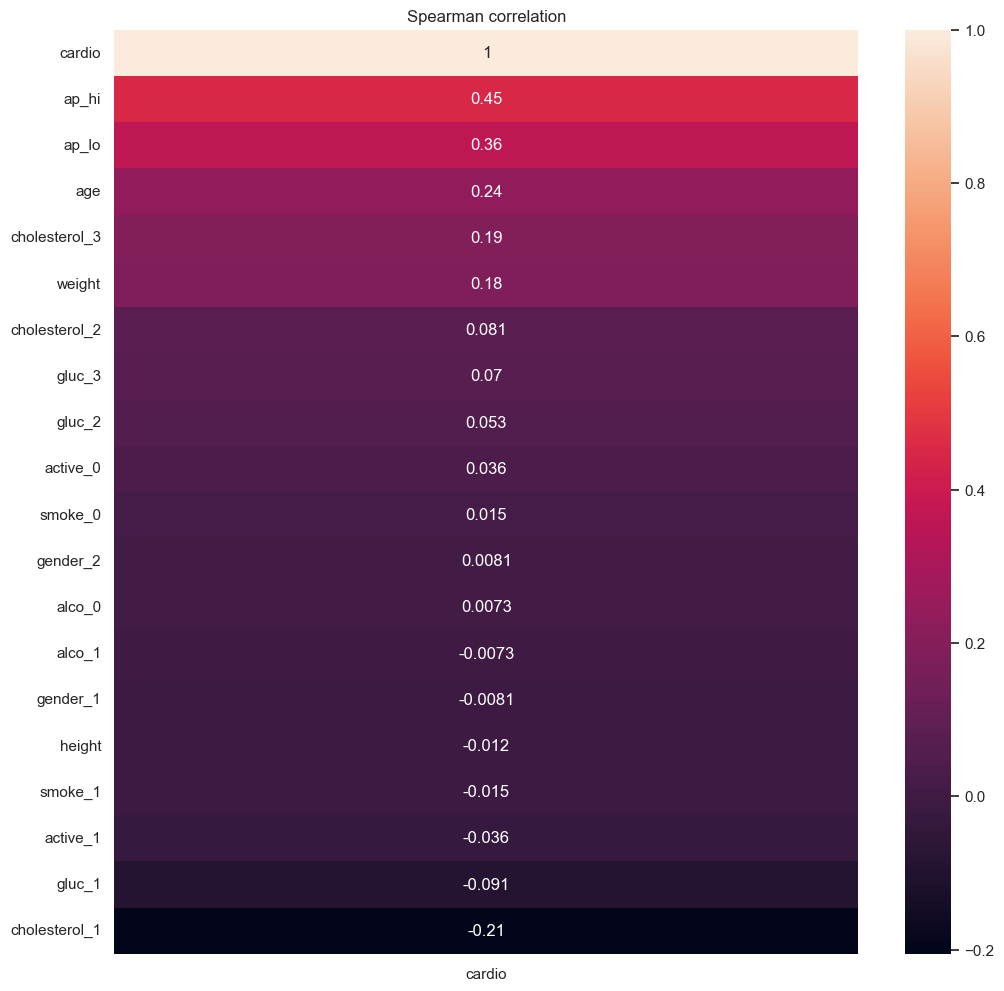

In [17]:
filtered_feature_names = [col for col in full_processed_df.columns 
                          if col != data_loader.target]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(12, 12))

### Correlation matrix for features which have high correlation with the target

In [18]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.1
)
high_correlated_features

['cholesterol_1', 'cholesterol_3', 'age', 'weight', 'ap_hi', 'ap_lo']

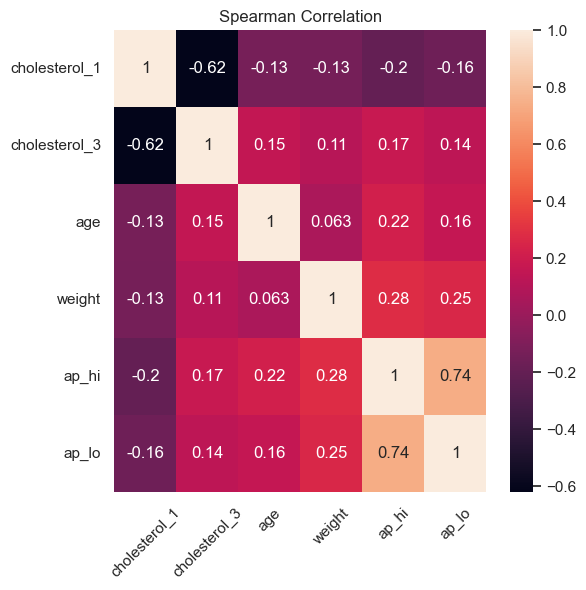

In [19]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features,
                       heatmap_size=(6, 6))

## Data preparation

In [20]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
        ('num', StandardScaler(), data_loader.numerical_columns),
    ],
    verbose_feature_names_out=False
)

In [21]:
base_flow_dataset = preprocess_dataset(data_loader, column_transformer, TEST_SET_FRACTION, DATASET_SPLIT_SEED)

## Tune RandomForest

In [22]:
models_params_for_tuning = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
}

In [23]:
# tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, DATASET_NAME, n_folds=3)
# tuned_params_df

In [24]:
# now = datetime.now(timezone.utc)
# date_time_str = now.strftime("%Y%m%d__%H%M%S")
# tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
# tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

## Analyze Feature Importance With Scikit-Learn

In [25]:
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'RandomForestClassifier': RandomForestClassifier(max_depth=50, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500, random_state=100)}


In [26]:
rf = models_config['RandomForestClassifier']
rf = rf.fit(base_flow_dataset.X_train_val, base_flow_dataset.y_train_val)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

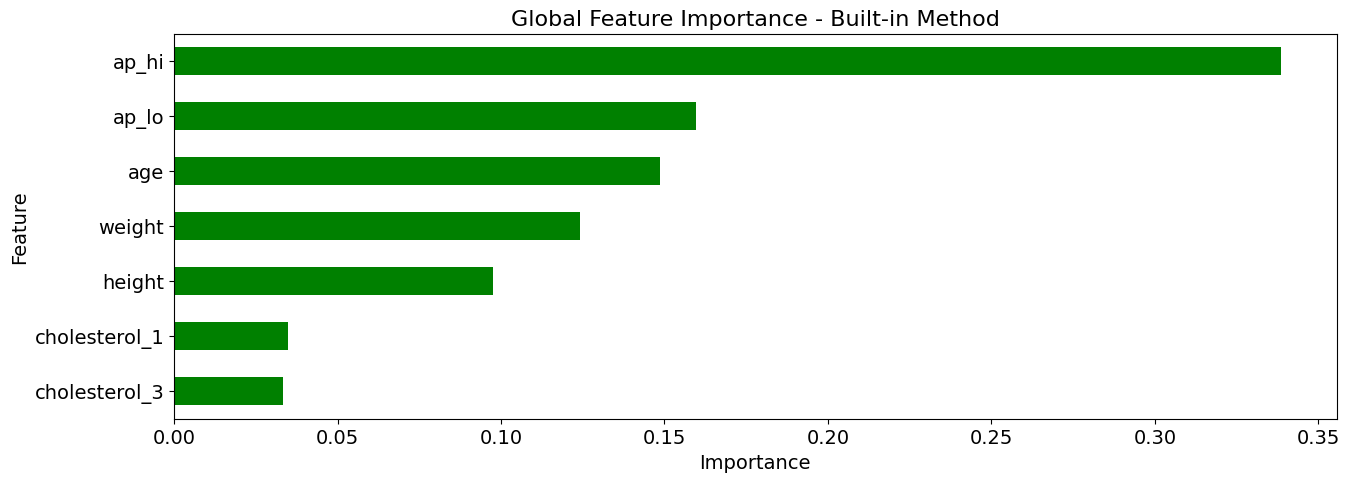

In [27]:
global_importances = pd.Series(rf.feature_importances_, index=base_flow_dataset.X_train_val.columns)
global_importances = global_importances[global_importances > 0.01]
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Global Feature Importance - Built-in Method", fontsize=16)